In [ ]:

!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import seaborn as sns
import pymc as pm

# **How does age effect efficient field goal percentage?**
---




In basketball, scoring efficiency, measured by effective field goal percentage (eFG%), is key to understanding a player's offensive impact. Unlike traditional field goal percentage, eFG% accounts for the added value of three-point shots, giving a fuller picture of a player’s scoring ability.

Using the basketball dataset provided by Mr. Arredondo, I aim to investigate how age influences eFG%, exploring if and how scoring efficiency changes across a player’s career. Younger players may rely on athleticism, while older players may use experience to make more strategic shot selections.  Through this study, we will find any age-related trends in scoring efficiency.

---

# Age vs. eFG% Data

---



First I need to remove all the useless data for my study so that my computer doesn't heat up and explode trying to run this. There are probably more efficient ways of cleaning up the data but I think its fine.

In [9]:
url_p = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
bsk_d = pd.read_csv(url_p)
#Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional



#removing stuff

del bsk_d['Player']
del bsk_d['Pos']
del bsk_d['Tm']
del bsk_d['G']
del bsk_d['GS']
del bsk_d['MP']
del bsk_d['FG']
del bsk_d['FGA']
del bsk_d['FT%']
del bsk_d['3P']
del bsk_d['3PA']
del bsk_d['FG%']
del bsk_d['2P']
del bsk_d['2PA']
del bsk_d['3P%']
del bsk_d['BLK']
del bsk_d['FT']
del bsk_d['FTA']
del bsk_d['2P%']
del bsk_d['ORB']
del bsk_d['DRB']
del bsk_d['TRB']
del bsk_d['AST']
del bsk_d['STL']
del bsk_d['TOV']
del bsk_d['PF']
del bsk_d['PTS']
del bsk_d['Player-additional']



In [10]:
bsk_d

,Age,eFG%
0,24,0.529
1,26,0.529
2,23,0.483
3,23,0.528
4,25,0.560
...,...,...
567,35,0.606
568,25,0.516
569,25,0.552
570,31,0.427


Most players seem to be within .4 and .6 eFG% so I'm wondering if there will be any noticable correlation.

In [11]:
bsk_d['Age'] = bsk_d['Age'].astype('category')

age_codes = bsk_d['Age'].cat.categories
age_idx = bsk_d['Age'].cat.codes.values


age_coords = {"age": age_codes}

<Axes: xlabel='eFG%', ylabel='Density'>

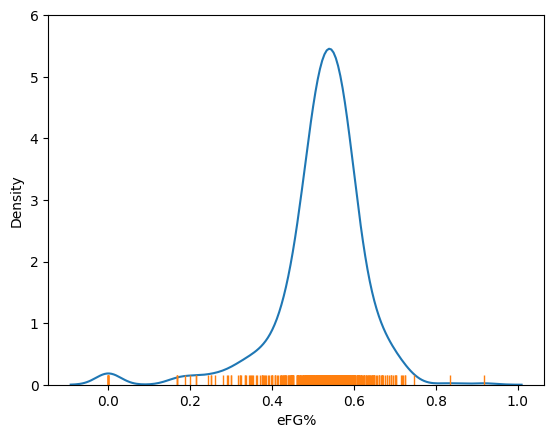

In [12]:
sns.kdeplot(data=bsk_d, x="eFG%")
sns.rugplot(data=bsk_d, x="eFG%")

Above we have our likelihood. We will use this for our heirarchal and non-heirarchal calculations later on.


---
# Non-Heirarchal Model:

Now that we have our data cut down to just age and eFG%, we'll use a non-hierarchical model which assumes independence among our categories. Although simpler, often times this type of model is enough for the scope of this class.

## Model 1

In [13]:
with pm.Model(coords=age_coords) as bsk_model:

    mu = pm.Normal('mu', mu=.55, sigma=2, dims="age")
    σ = pm.HalfNormal('σ', sigma=1, dims="age")

    nu = pm.Exponential('nu', lam=1, dims="age")
    y = pm.StudentT('y', mu=mu[age_idx], sigma=σ[age_idx], nu=nu[age_idx], observed=bsk_d["eFG%"])


    thething = pm.sample()





/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

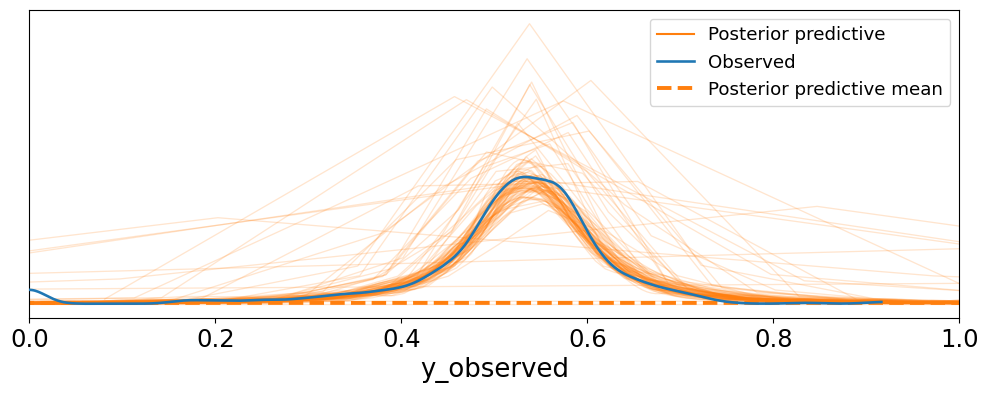

In [14]:
pm.sample_posterior_predictive(thething, model=bsk_model, extend_inferencedata=True)

az.plot_ppc(thething, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

plt.xlim(0, 1)

plt.show()


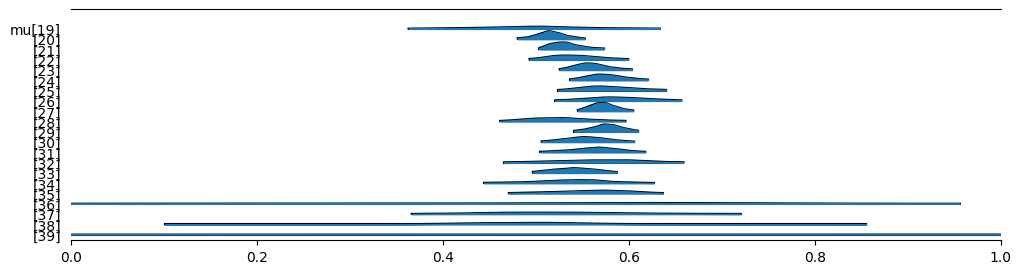

In [70]:
az.plot_forest(thething, var_names=['mu'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.95)
plt.xlim(0, 1)
plt.show()

# 💔
I feel hurt, betrayed, and heartbroken (kidding ofc). The posterior predictive curves seem to trace the function quite accurately, at least if you ignore the couple "loose strands" that are taking bizzare paths above the curve. I think that's just the computer glitching because a curve shouldn't pivot that hard. Either way, that isn't the main problem. What is the PPC mean doing? why is it just a straight line on the floor of the curve? I really hope this is just a small miscalculation by the computer. I'll try running a couple of more times.

After tweaking with the code and rerunning the PPC 10+ times, given that it takes around 5 minutes every run, I've officially given up on this type of curve. It stays as a flat line while it's seperate PPC lines are doing an OK job following the data.

In [15]:
with pm.Model(coords=age_coords) as num2nonh:
  #kinda super lost so asked Neev for help
  #he showed me a similar model to what he did
    mu = pm.Normal('mu', mu=0.55, sigma=2, dims="age")
    sigma = pm.HalfNormal('sigma', sigma=2, dims="age")

    a = pm.HalfNormal('a', sigma=2, dims="age")
    b = pm.HalfNormal('b', sigma=2, dims="age")

    y = pm.SkewStudentT('y', mu=mu[age_idx], sigma=sigma[age_idx], a=a[age_idx], b=b[age_idx], observed=bsk_d["eFG%"])

    # Sampling
    thething = pm.sample()





/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5417: RuntimeWarning: divide by zero 
encountered in divide
  return d2 / d3

(0.0, 1.0)

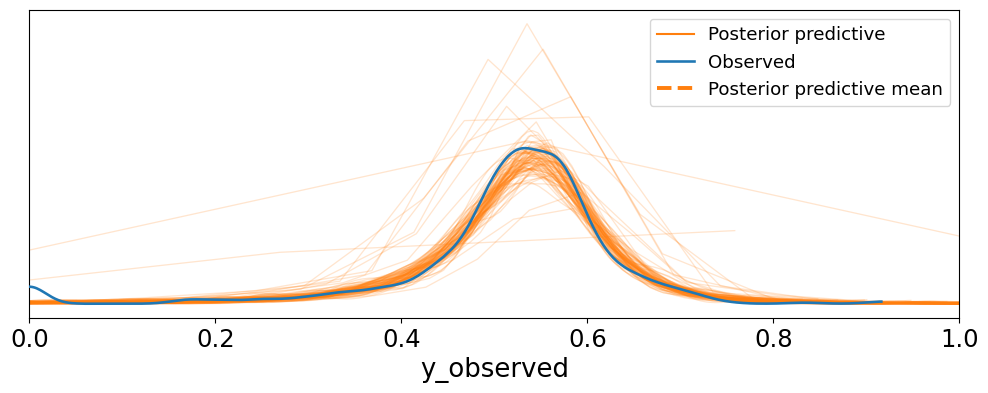

In [58]:
pm.sample_posterior_predictive(thething, model=num2nonh, extend_inferencedata=True)

plot = az.plot_ppc(thething, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plot.set_xlim(0, 1)


# 💔💔💔

Ok clearly something is wrong with my code. But I don't want to admit to that so I'm going to continue to bleieve my computer is the probelem. Maybe because this unit is so memoriy intensive on the computer it causes my computer to crash halfway through each PPC. 100 samples does seem like a lot, so I'll try using only 10 samples. Maybe that will help with run time too.

Output()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5417: RuntimeWarning: divide by zero 
encountered in divide
  return d2 / d3

(0.0, 1.0)

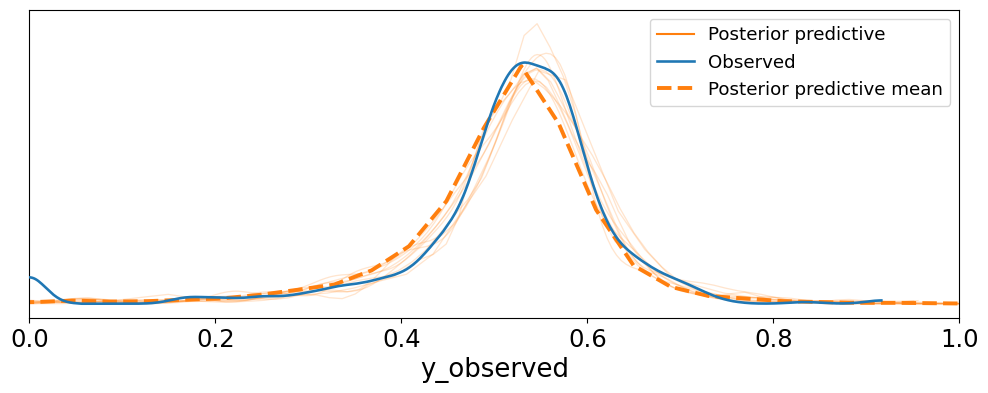

In [57]:
pm.sample_posterior_predictive(thething, model=num2nonh, extend_inferencedata=True)

plot = az.plot_ppc(thething, num_pp_samples=10, figsize=(12, 4), colors=["C1", "C0", "C1"])
plot.set_xlim(0, 1)


# Success! (kind of)

Well, at least my curve is finally not a flat line. It's definetely not a perfect PPC mean, with the largest deviations from 0.4 to 0.6. However, it follows the relative shape of the observed line and I don't want to see another flat line in a different model, so I think I'll call it a day at this. Hopefully I have a lot more luck in heirarchal.

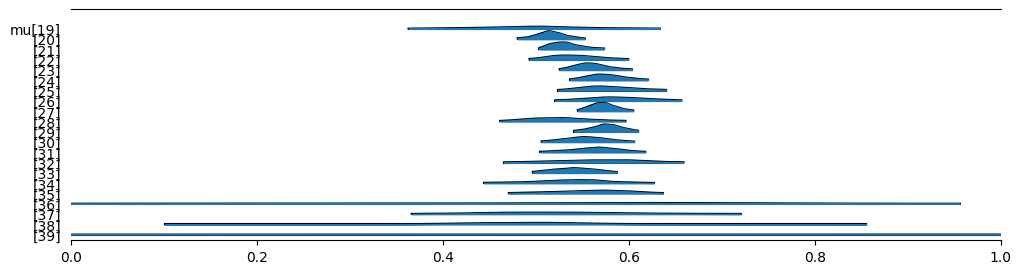

In [72]:
az.plot_forest(thething, var_names=['mu'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.95)
plt.xlim(0, 1)
plt.show()

Notable features


*   Large span for rookies and older players.
*   Very tight distribution for players 20 - 30 years old, which is usually a players prime.
*   Slightly curves at around 26 years of age, with youger and older players having a lower average eFG%. I'm not sure how significant this is though.



---
# Heirarchal Model:

After such an awkward time working with non-heirarchal models, lets hope I have more luck with heirarchal models, which does not assume independence.

In [19]:
with pm.Model(coords=age_coords) as basketball_model:
    mu_pop = pm.Beta("mu_pop", alpha=2, beta=20)
    nu_pop = pm.Gamma("nu_pop", mu=55, sigma=45)

    mu_age = pm.Beta("mu_age", mu=mu_pop, nu=nu_pop, dims="age")
    nu_age = pm.Gamma("nu_age", mu=55, sigma=45, dims="age")

    # player eFG% based on age
    theta = pm.Beta("theta", mu=mu_age[age_idx], nu=nu_age[age_idx])

    # lklhd for  eFG%
    _ = pm.Normal("efg_obs", mu=theta, sigma=0.1, observed=bsk_d['eFG%'])

    idata_basketball = pm.sample(target_accept=0.95)


/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in efg_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

Output()

(0.0, 1.0)

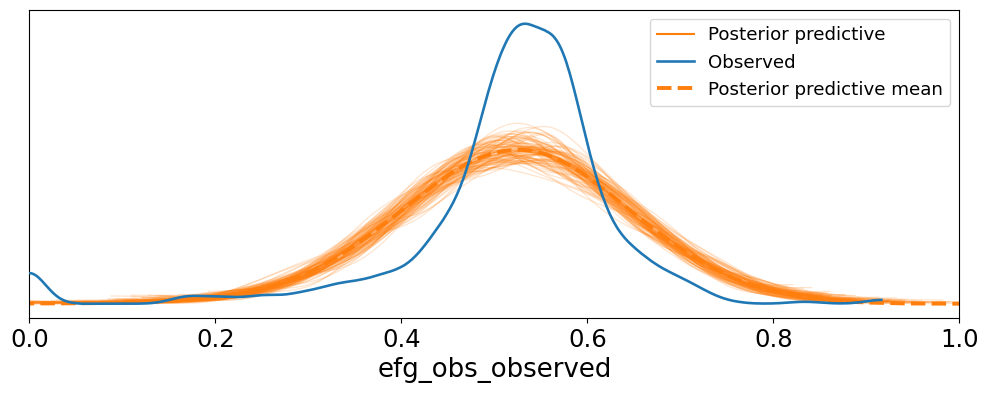

In [21]:
pm.sample_posterior_predictive(idata_basketball, model=basketball_model, extend_inferencedata=True)

plot = az.plot_ppc(idata_basketball, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plot.set_xlim(0, 1)


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'efg_obs'}>,
        <Axes: title={'center': 'efg_obs'}>],
       [<Axes: title={'center': 'efg_obs_unobserved'}>,
        <Axes: title={'center': 'efg_obs_unobserved'}>],
       [<Axes: title={'center': 'mu_age'}>,
        <Axes: title={'center': 'mu_age'}>],
       [<Axes: title={'center': 'mu_pop'}>,
        <Axes: title={'center': 'mu_pop'}>],
       [<Axes: title={'center': 'nu_age'}>,
        <Axes: title={'center': 'nu_age'}>],
       [<Axes: title={'center': 'nu_pop'}>,
        <Axes: title={'center': 'nu_pop'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

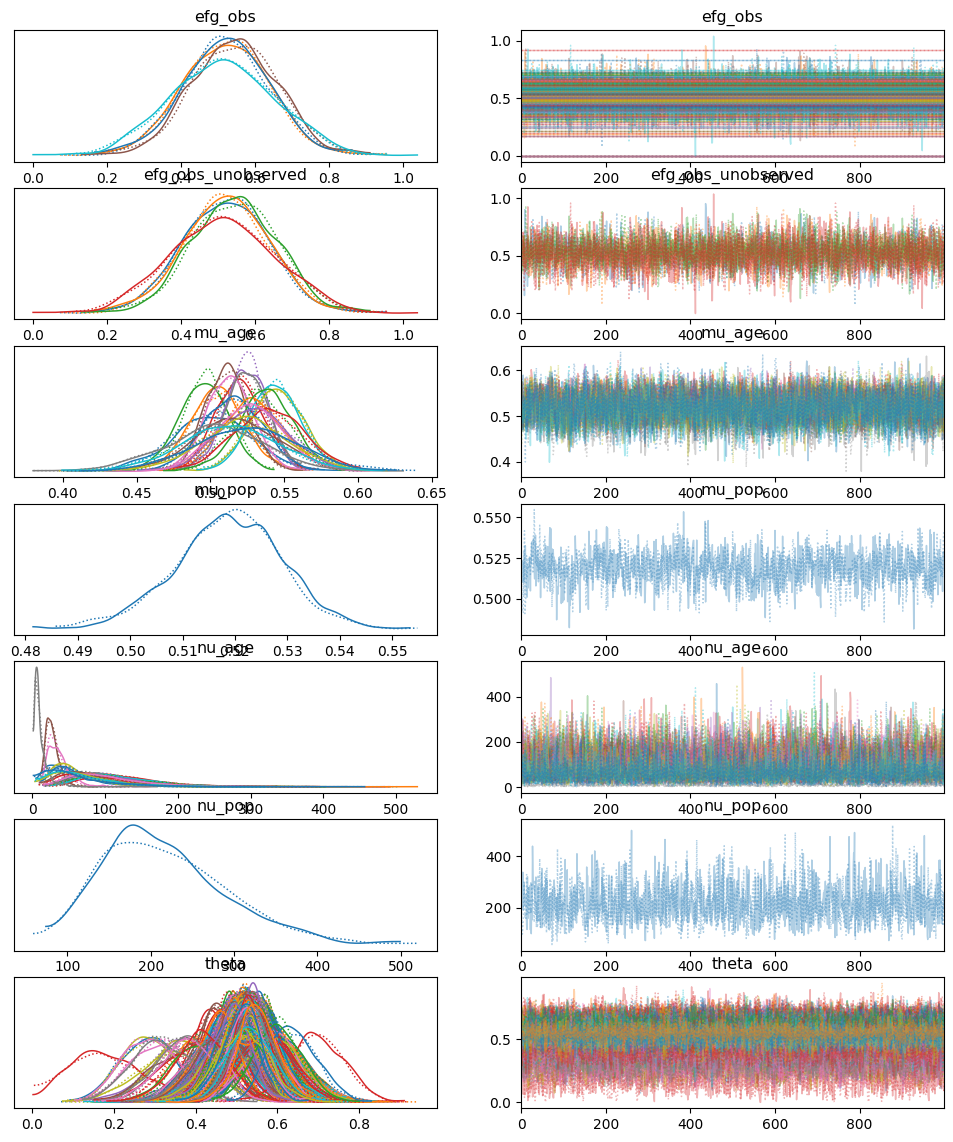

In [22]:
az.plot_trace(idata_basketball)

In [23]:
az.rhat(idata_basketball)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset> Size: 19kB
Dimensions:                   (efg_obs_dim_0: 572, efg_obs_unobserved_dim_0: 4,
                               age: 21, theta_dim_0: 572)
Coordinates:
  * efg_obs_dim_0             (efg_obs_dim_0) int64 5kB 0 1 2 3 ... 569 570 571
  * efg_obs_unobserved_dim_0  (efg_obs_unobserved_dim_0) int64 32B 0 1 2 3
  * age                       (age) int64 168B 19 20 21 22 23 ... 35 36 37 38 39
  * theta_dim_0               (theta_dim_0) int64 5kB 0 1 2 3 ... 569 570 571
Data variables:
    efg_obs                   (efg_obs_dim_0) float64 5kB nan nan ... nan nan
    efg_obs_unobserved        (efg_obs_unobserved_dim_0) float64 32B 1.0 ... ...
    mu_age                    (age) float64 168B 1.001 1.001 ... 1.003 1.002
    mu_pop                    float64 8B 1.0
    nu_age                    (age) float64 168B 1.005 1.002 ... 1.0 0.9993
    nu_pop                    float64 8B 1.002
    theta                     (theta_dim_0) float64 5kB 1.007 1.0 ... 1.0 1.0

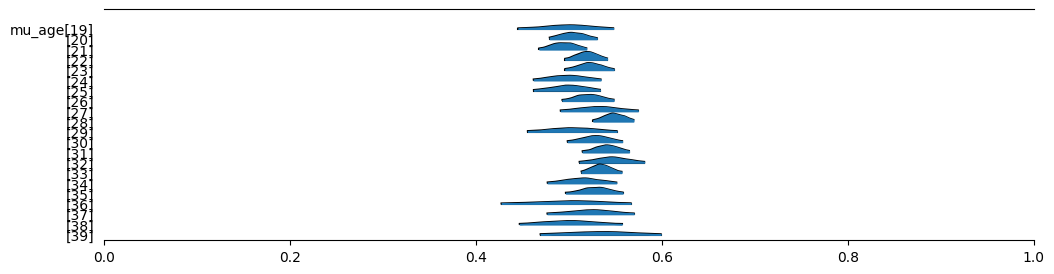

In [73]:
az.plot_forest(idata_basketball, var_names=['mu_age'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.95)
plt.xlim(0, 1)
plt.show()

# Very Good Start!

I'm on top of the world right now. My line isn't completetly flat! Obviously, it doesn't match at all, but I think if I tweak the standard deviation, sigma, a little bit it should end up matching.

The plot trace diagram and the r_hat don't seem that bad, but I can definitely do better. The plot trace diagram does miss some crucial details, however, like a the divot in the nu_age curve. The r_hat tends to stay within 0.99 and 1.005, next attempt I'll try to make sure most of the r_hat values are within 1 and 1.001.

Additionally, The forest diagram seems to be a lot more uniform and tight. There isn't as big of a divot for players ages 20-30 and ages like 36-39 don't span from 0 to 1  but rather from 0.5 to 0.6.

In [75]:
with pm.Model(coords=age_coords) as basketball_model:
    mu_pop = pm.Beta("mu_pop", alpha=2, beta=20)
    nu_pop = pm.Gamma("nu_pop", mu=55, sigma=45)

    mu_age = pm.Beta("mu_age", mu=mu_pop, nu=nu_pop, dims="age")
    nu_age = pm.Gamma("nu_age", mu=55, sigma=45, dims="age")

    # player eFG% based on age
    theta = pm.Beta("theta", mu=mu_age[age_idx], nu=nu_age[age_idx])

    # lklhd for  eFG%
    _ = pm.Normal("efg_obs", mu=theta, sigma=0.01, observed=bsk_d['eFG%']) #changed sigma to 0.01 from  0.1

    idata_basketball = pm.sample(target_accept=0.95)


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:03:17

Output()

(0.0, 1.0)

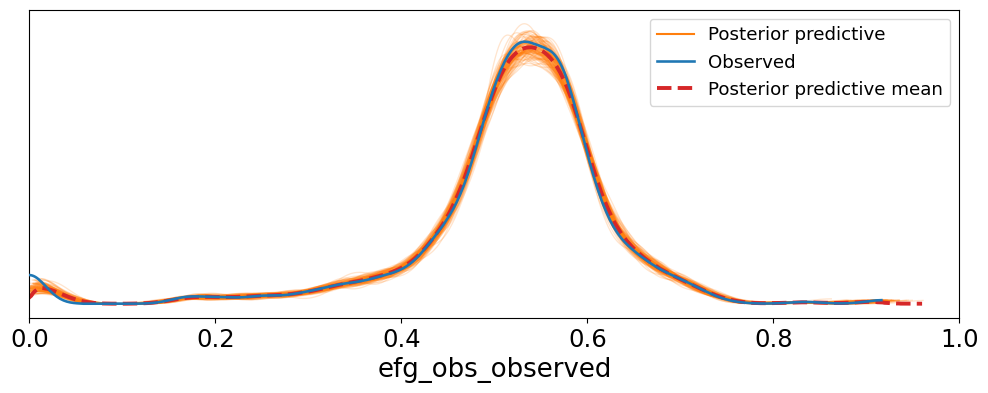

In [40]:
pm.sample_posterior_predictive(idata_basketball, model=basketball_model, extend_inferencedata=True)

plot = az.plot_ppc(idata_basketball, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C3"])
plot.set_xlim(0, 1)


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'efg_obs'}>,
        <Axes: title={'center': 'efg_obs'}>],
       [<Axes: title={'center': 'efg_obs_unobserved'}>,
        <Axes: title={'center': 'efg_obs_unobserved'}>],
       [<Axes: title={'center': 'mu_age'}>,
        <Axes: title={'center': 'mu_age'}>],
       [<Axes: title={'center': 'mu_pop'}>,
        <Axes: title={'center': 'mu_pop'}>],
       [<Axes: title={'center': 'nu_age'}>,
        <Axes: title={'center': 'nu_age'}>],
       [<Axes: title={'center': 'nu_pop'}>,
        <Axes: title={'center': 'nu_pop'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

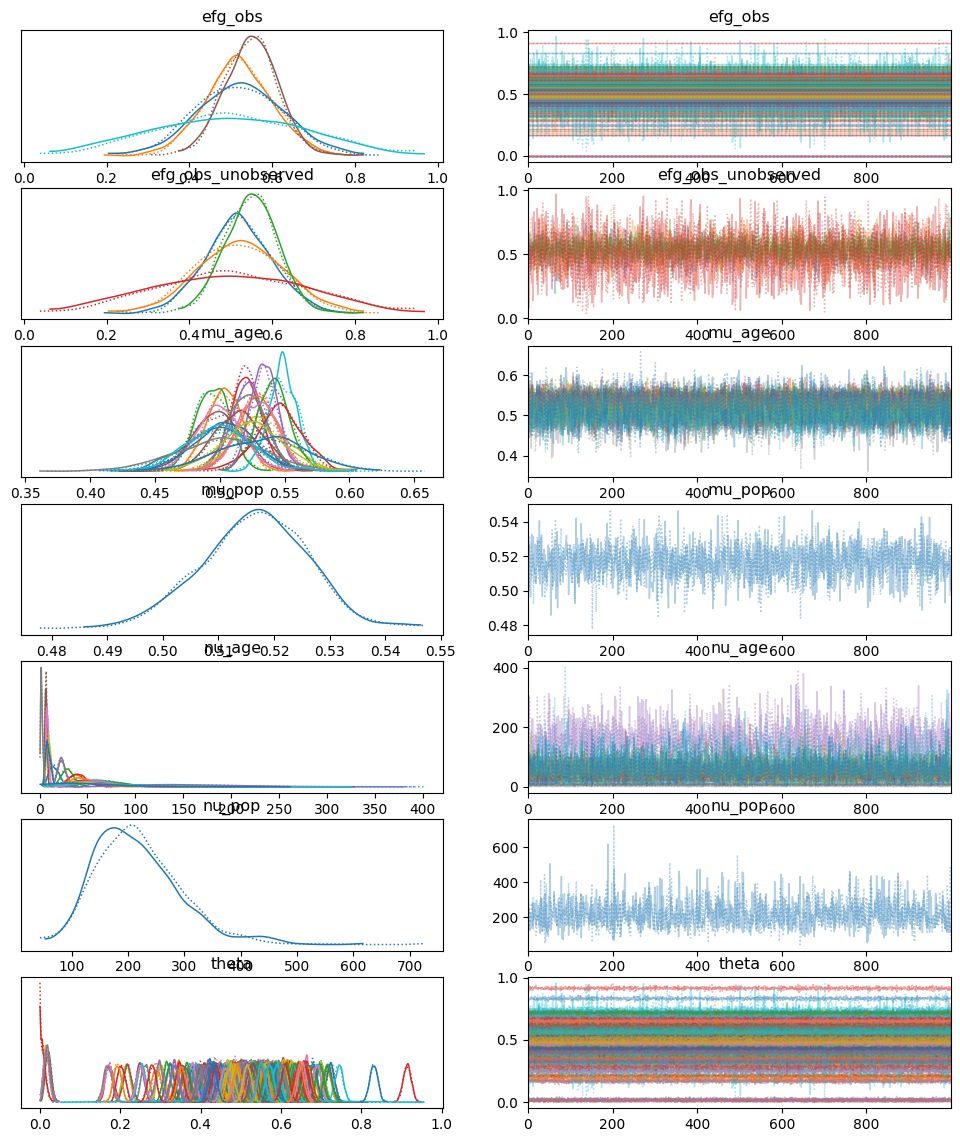

In [41]:
az.plot_trace(idata_basketball)

In [42]:
az.rhat(idata_basketball)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset> Size: 19kB
Dimensions:                   (efg_obs_dim_0: 572, efg_obs_unobserved_dim_0: 4,
                               age: 21, theta_dim_0: 572)
Coordinates:
  * efg_obs_dim_0             (efg_obs_dim_0) int64 5kB 0 1 2 3 ... 569 570 571
  * efg_obs_unobserved_dim_0  (efg_obs_unobserved_dim_0) int64 32B 0 1 2 3
  * age                       (age) int64 168B 19 20 21 22 23 ... 35 36 37 38 39
  * theta_dim_0               (theta_dim_0) int64 5kB 0 1 2 3 ... 569 570 571
Data variables:
    efg_obs                   (efg_obs_dim_0) float64 5kB nan nan ... nan nan
    efg_obs_unobserved        (efg_obs_unobserved_dim_0) float64 32B 1.0 ... ...
    mu_age                    (age) float64 168B 1.001 0.9993 ... 1.003 0.9995
    mu_pop                    float64 8B 0.9993
    nu_age                    (age) float64 168B 1.0 0.9997 1.005 ... 1.0 1.002
    nu_pop                    float64 8B 1.001
    theta                     (theta_dim_0) float64 5kB 1.004 1.001 ... 1.002

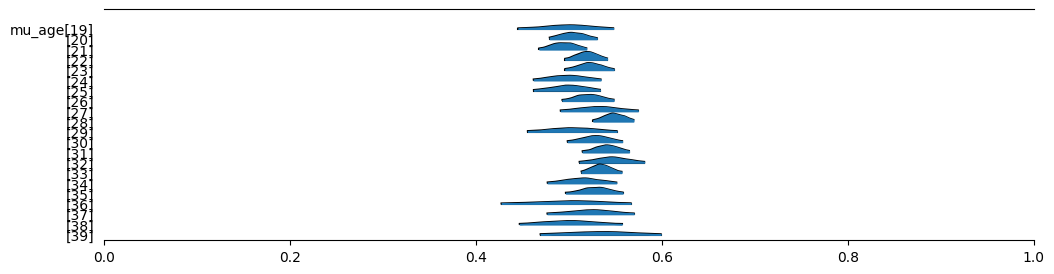

In [74]:
az.plot_forest(idata_basketball, var_names=['mu_age'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.95)
plt.xlim(0, 1)
plt.show()

# Wow!
This is such a beatiful sight to see. The PPC is almost spot on  and it even emiulates the slgiht bump near the eFG% = 0.0 area. r_hat and the plot trace diagram also seem to match better than the preivous herirachal model (obviously). Additionally, this model is miles better than any of the non-heirarchal models.

The forest plot looks similar to the one in the first model, so look back on that for the improvements.




---

# Conclusion

From what I can see, both the non-heirarchal and heriarchal models look to 0.57 eFG%. The non-heirarchal model seems to flatten a bit more at the top, but it's center doesn't shift. However, based on what I've seen in the little amount of basketball related content I've watched on YouTube, I've heard the game is growing to be more attacking and more points are being scored, so I think the eFG% per player is actually increasing slightly, telling me that in the next couple of years the eFG% could grow to maybe even 0.6.

As for Age vs. eFG%, we see it stay more or less uniform for the heirarchal model while having a much larger divot for the non-heirarchal.



*   Non-heirarchal - As you enter the 20-30 age category, the range of player's eFG% become a lot tighter. I believe this is because player's in their prime years, so they are expected to be scoring high. Any deviation from this, especially a lower eFG%, means they don't have any more potential and are most likely booted from the league. As for older and rookies, they have more use than just their scoring ability. Rookies are sought after in the NBA because of their future potential, not their current form. Older 'uncs' within the NBA are incldued in teams becuase of their leadership and experience.
*   Hierarchal - We see similar patterns, but in a less amplified way. Additionally, due to the more accurate graph, we see a more confident model, but we still see higher spreads of distributions among eFG% for rookies and veterans. Veterans like LeBron are still utilized in their team for their scoring ability, while others are on the bench or leadign their team.

I believe the model is good enough and gives us insight on the age dynamics in sports.




